In [1]:
import numpy as np
from random import seed
from random import sample
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from os.path import join
from skimage.measure import regionprops_table
import matplotlib.pyplot as plt

In [8]:
nucleiPath = '/Volumes/Aortas/Aorta/segmentations/inducedRainbow/nuclei/5-60/C5RB-048_5-60'
clusterPath = '/Volumes/Aortas/Aorta/segmentations/inducedRainbow/red/5-60/C5RB-048/clusterSizeRedP5-60_aorta_C5RB-048_60Thres_updated.npy'
savePath = '/Volumes/Aortas/Aorta/results/inducedRainbow/randomness/5-60/C5RB-050'
aorta = '5-60Red_C5RB050.csv'

In [9]:
scalingFactor = 10000
for i in range(4):
    #build row block
    nuc1 =np.load(join(nucleiPath, "Cropped_IMG-" + str(4*i +1) + '_seg.npy'), allow_pickle=True).item()['masks']
    nuc2 =np.load(join(nucleiPath, "Cropped_IMG-" + str(4*i +2) + '_seg.npy'), allow_pickle=True).item()['masks']
    nuc3 =np.load(join(nucleiPath, "Cropped_IMG-" + str(4*i +3) + '_seg.npy'), allow_pickle=True).item()['masks']
    nuc4 =np.load(join(nucleiPath, "Cropped_IMG-" + str(4*i +4) + '_seg.npy'), allow_pickle=True).item()['masks']
    nuc1 = nuc1 + scalingFactor *(4*i +1)
    nuc1[nuc1 == (scalingFactor *(4*i +1))] = 0
    nuc2 = nuc2 + scalingFactor *(4*i +2)
    nuc2[nuc2 == (scalingFactor *(4*i +2))] = 0
    nuc3 = nuc3 + scalingFactor *(4*i +3)
    nuc3[nuc3 == (scalingFactor *(4*i +3))] = 0
    nuc4 = nuc4 + scalingFactor *(4*i +4)
    nuc4[nuc4 == (scalingFactor *(4*i +4))] = 0

    row = np.concatenate((nuc1, nuc2, nuc3, nuc4), axis = 1)
    if i == 0:
        nucImage = row
    else:
        nucImage = np.concatenate((nucImage, row), axis = 0)

In [10]:
def centeroidPoints(arr):
    length = arr.shape[0]
    sum_y = np.sum(arr[:, 0])
    sum_x = np.sum(arr[:, 1])
    return sum_y/length, sum_x/length

In [11]:
prop_dict = regionprops_table(nucImage, properties = ('label', 'centroid'))
df = pd.DataFrame(prop_dict)
nucIDs = df['label'].tolist()

In [12]:
cluster = np.load(clusterPath, allow_pickle=True).item()

In [13]:
singletons = []
doublets = []
higher = []
marked = []
for key in cluster:
    if len(cluster[key]) == 1:
        singletons.append(df[df['label'] == cluster[key][0]][['centroid-0', 'centroid-1']].to_numpy()[0])
        marked.append(df[df['label'] == cluster[key][0]][['centroid-0', 'centroid-1']].to_numpy()[0])
    elif len(cluster[key]) == 2:
        points = np.asarray([df[df['label'] == cluster[key][i]][['centroid-0', 'centroid-1']].to_numpy()[0] for i in range(len(cluster[key]))])
        centroid = centeroidPoints(points)
        doublets.append(centroid)
        marked.append(centroid)
    else:
        points = np.asarray([df[df['label'] == cluster[key][i]][['centroid-0', 'centroid-1']].to_numpy()[0] for i in range(len(cluster[key]))])
        centroid = centeroidPoints(points)
        higher.append(centroid)
        marked.append(centroid)

markedArray = np.asarray(marked)
singletonsArray = np.asarray(singletons)
doubletsArray = np.asarray(doublets)
higherArray = np.asarray(higher)

In [14]:
def kNN(array, neighbor):
    nbrs = NearestNeighbors(n_neighbors=neighbor, algorithm='ball_tree').fit(array)
    distances, indices = nbrs.kneighbors(array)
    return nbrs, distances, indices

In [15]:
#marked real
nbrsMarkedReal, distancesMarkedReal, indicesMarkedReal = kNN(markedArray, 6)

#singletonsReal
nbrsSingletonsReal, distancesSingletonsReal, indicesSingletonsReal = kNN(singletonsArray, 6)

#doubletsReal
nbrsDoubletsReal, distancesDoubletsReal, indicesDoubletsReal = kNN(doubletsArray, 6)

#higherReal
nbrsHigherReal, distancesHigherReal, indicesHigherReal = kNN(higherArray, 6)

In [16]:
def randomkNNDistances(len):
    selectedRandom = sample(nucIDs, len)
    dfRandom = df[df['label'].isin(selectedRandom)]
    nucCoordRandom = dfRandom[['centroid-0', 'centroid-1']].to_numpy()
    nbrsRandom = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(nucCoordRandom)
    distancesRand, indicesRandom = nbrsRandom.kneighbors(nucCoordRandom)
    return distancesRand

In [17]:
seed(42)
distancesRandom = []
markedRandom = []
singletonRandom = []
doubletRandom = []
higherRandom = []
for _ in range(1000):
    markedRandom.append(np.asarray(randomkNNDistances(len(markedArray))))
    singletonRandom.append(np.asarray(randomkNNDistances(len(singletonsArray))))
    doubletRandom.append(np.asarray((randomkNNDistances(len(doubletsArray)))))
    higherRandom.append(np.asarray(randomkNNDistances(len(higherArray))))
distancesMarkedRandom = np.asarray(markedRandom)
distancesSingletonsRandom = np.asarray(singletonRandom)
distancesDoubletsRandom = np.asarray(doubletRandom)
distancesHigherRandom = np.asarray(higherRandom)

In [221]:
k=1

In [222]:
np.mean(distancesMarkedReal[:,k])

38.524314644967625

In [223]:
np.mean(distancesMarkedRandom[:,:,k])

42.75325251869774

In [224]:
np.mean(distancesSingletonsReal[:,k])

43.928347257487026

In [225]:
np.mean(distancesSingletonsRandom[:,:,k])

54.327009699685775

In [226]:
np.mean(distancesDoubletsReal[:,k])

82.1854494244663

In [227]:
np.mean(distancesDoubletsRandom[:,:,k].flatten())

86.96451516342397

In [228]:
np.mean(distancesHigherReal[:,k])

114.61139054483097

In [229]:
np.mean(distancesHigherRandom[:,:,k].flatten())

124.84278265911774

In [ ]:
#save results

In [159]:
distancesMarkedRandom2D = np.asarray([distancesMarkedRandom[:,:,0].flatten(), distancesMarkedRandom[:,:,1].flatten(), distancesMarkedRandom[:,:,2].flatten(), distancesMarkedRandom[:,:,3].flatten(), distancesMarkedRandom[:,:,4].flatten(), distancesMarkedRandom[:,:,5].flatten()])

distancesSingletonsRandom2D = np.asarray([distancesSingletonsRandom[:,:,0].flatten(), distancesSingletonsRandom[:,:,1].flatten(), distancesSingletonsRandom[:,:,2].flatten(), distancesSingletonsRandom[:,:,3].flatten(), distancesSingletonsRandom[:,:,4].flatten(), distancesSingletonsRandom[:,:,5].flatten()])

distancesDoubletsRandom2D = np.asarray([distancesDoubletsRandom[:,:,0].flatten(), distancesDoubletsRandom[:,:,1].flatten(), distancesDoubletsRandom[:,:,2].flatten(), distancesDoubletsRandom[:,:,3].flatten(), distancesDoubletsRandom[:,:,4].flatten(), distancesDoubletsRandom[:,:,5].flatten()])

distancesHigherRandom2D = np.asarray([distancesHigherRandom[:,:,0].flatten(), distancesHigherRandom[:,:,1].flatten(), distancesHigherRandom[:,:,2].flatten(), distancesHigherRandom[:,:,3].flatten(), distancesHigherRandom[:,:,4].flatten(), distancesHigherRandom[:,:,4].flatten()])

In [162]:
np.savetxt(join(savePath,'distancesMarkedReal_' + aorta), distancesMarkedReal, delimiter=",")
np.savetxt(join(savePath,'distancesMarkedRandom_' + aorta), distancesMarkedRandom2D, delimiter=",")
np.savetxt(join(savePath,'distancesSingletonsReal_' + aorta), distancesSingletonsReal, delimiter=",")
np.savetxt(join(savePath,'distancesSingletonsRandom_' + aorta), distancesSingletonsRandom2D, delimiter=",")
np.savetxt(join(savePath,'distancesDoubletsReal_' + aorta), distancesDoubletsReal, delimiter=",")
np.savetxt(join(savePath,'distancesDoubletsRandom_' + aorta), distancesDoubletsRandom2D, delimiter=",")
np.savetxt(join(savePath,'distancesHigherReal_' + aorta), distancesHigherReal, delimiter=",")
np.savetxt(join(savePath,'distancesHigherRandom_' + aorta), distancesHigherRandom2D, delimiter=",")

In [168]:
len(distancesMarkedReal[:,k])

370

In [18]:
k = 1

(0.0, 300.0)

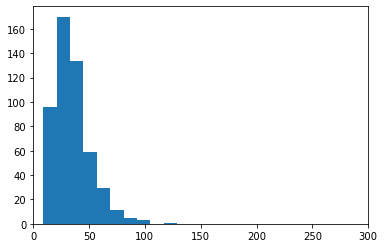

In [19]:
plt.hist(distancesMarkedReal[:,k])
plt.xlim(0,300)

(0.0, 300.0)

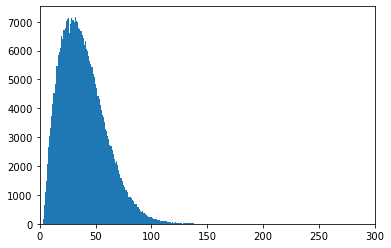

In [45]:
plt.hist(distancesMarkedRandom[:,:,k].flatten(), bins = 200)
plt.xlim(0,300)

In [61]:
k = 5

(0.0, 400.0)

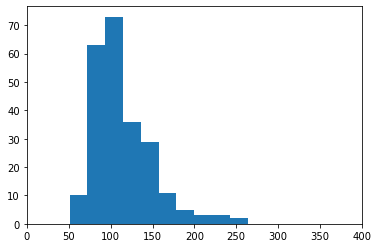

In [84]:
plt.hist(distancesSingletonsReal[:,k])
plt.xlim(0,400)

(0.0, 400.0)

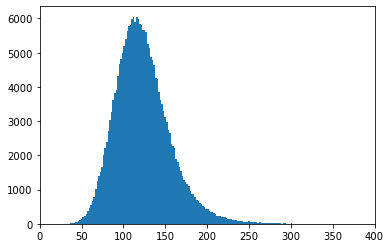

In [85]:
plt.hist(distancesSingletonsRandom[:,:,k].flatten(), bins=200)
plt.xlim(0,400)

In [79]:
k = 5

(0.0, 600.0)

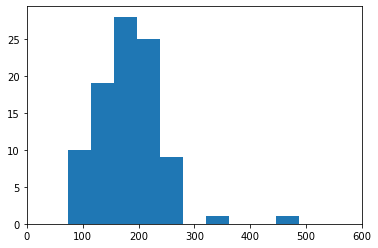

In [83]:
plt.hist(distancesDoubletsReal[:,k])
plt.xlim(0,600)

(0.0, 600.0)

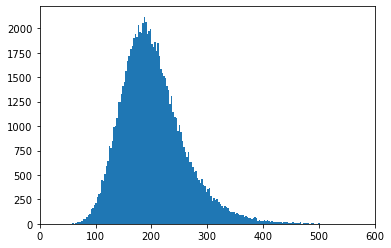

In [82]:
plt.hist(distancesDoubletsRandom[:,:,k].flatten(), bins = 200)
plt.xlim(0,600)

In [98]:
k = 5

(0.0, 300.0)

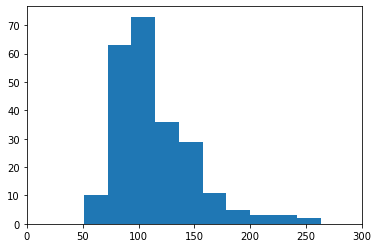

In [144]:
plt.hist(distancesSingletonsReal[:,k])
plt.xlim(0,300)

(0.0, 850.0)

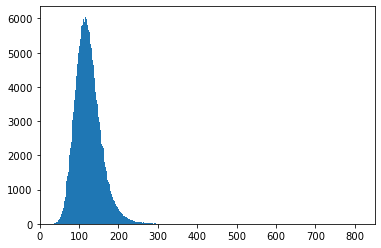

In [130]:
plt.hist(distancesSingletonsRandom[:,:,k].flatten(), bins = 200)
plt.xlim(0,850)

In [122]:
plt.hist(distancesSingletonsRandom[:,:,k].flatten(), bins = 200)
plt.xlim(0,850)

In [20]:
k=1

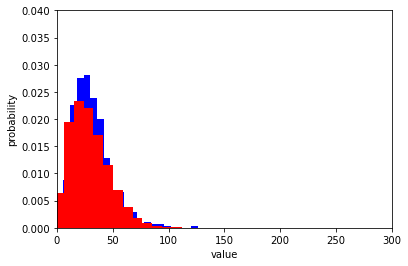

In [24]:
# Your code.
n, bins, patches = plt.hist(distancesMarkedReal[:,k], 20, facecolor='blue', label="Real", align='left', density=True)
n, bins, patches = plt.hist(distancesMarkedRandom[:,:,k].flatten(), 20, facecolor='red',label="Random",align='left',density=True)
plt.xlabel('value')
plt.ylabel('probability')
plt.title('')
plt.xlim(0,300)
plt.ylim(0,0.04)
#plt.legend()

# My addition.
import matplotlib.ticker as mtick
def div_10(x, *args):
    """
    The function that will you be applied to your y-axis ticks.
    """
    x = float(x)*len(distancesHigherReal[:,k])
    return "{:.1f}".format(x)
# Apply to the major ticks of the y-axis the function that you defined.
ax = plt.gca()
#ax.yaxis.set_major_formatter(mtick.FuncFormatter(div_10))
plt.show()

(-4.0, 4.0)

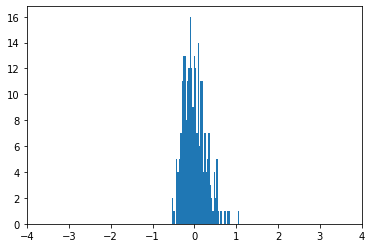

In [53]:
k = 5
plt.hist((distancesSingletonsReal[:,k]/np.mean(distancesSingletonsRandom[:,:,k].flatten())) -1, bins = 50)
plt.xlim(-4,4)

In [131]:
k = 5

In [132]:
np.mean(distancesMarkedReal[:,k])

89.05835455535912

In [133]:
np.mean(distancesMarkedRandom[:,:,k])

96.93205847020234

In [134]:
np.mean(distancesSingletonsReal[:,k])

114.15767189764152

In [135]:
np.mean(distancesSingletonsRandom[:,:,k])

123.2395873897276

In [136]:
np.mean(distancesDoubletsReal[:,k])

183.8761124595404

In [137]:
np.mean(distancesDoubletsRandom[:,:,k].flatten())

203.32167909713993

In [138]:
np.mean(distancesHigherReal[:,k])

340.67756213700335

In [139]:
np.mean(distancesHigherRandom[:,:,k].flatten())

317.34342010977736

119.86272120187259

In [54]:
# positive cells

In [54]:
markedArray
singletonsArray = np.asarray(singletons)
doubletsArray = np.asarray(doublets)
higherArray = np.asarray(higher)

In [56]:
len(singletonsArray) + len(doubletsArray) + len(higherArray)

508

In [57]:
len(markedArray)

508

In [59]:
# divided clusters
1-(len(singletonsArray)/len(markedArray))

0.5019685039370079

In [68]:

nucNumber = len(np.unique(nucImage))
positiveCells, dividedCells = 0, 0
for i in range(len(markedArray)):
    positiveCells += len(markedArray[i])
    dividedCells += (len(markedArray[i]) - 1)

In [72]:
# positive cells
positiveCells/nucNumber

0.05893955215222184

In [74]:
# divided cells
dividedCells/positiveCells

0.5